# This notebook is to compare caffe and nvdla with 42 images.

## TODO: 

### Implement funtions:

* catch all filenames 
* classify filenames by image name (total 41 images)
* according image name to analyze every layer difference between caffe and nvdla (total 39 layers)

### Envirnment 
* nvdla/sw @ **2018/6/30**
* nvdla/hw @ **nvdlav1**
* model: BVLC/caffe example cifar10 quick, **iter. 4000**
* Input images were not any processed on NVDLA and Caffe, so accurarcy is **very bad**. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob
import scipy
import csv
import itertools
from natsort import natsorted

## Configure max read file size

In [2]:
# Set the csv limitation 
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

# Function Defination
## Read files

In [3]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [4]:
def getfrombigtxt(fname, delimiter=' '):
    tmp = []
    with open(fname, 'r') as f: # note text mode, not binary
        for row in csv.reader(f):
            for elements in row[0].split(delimiter):
#                 tmp.append(map(float, elements))
                tmp.append((elements))
    del tmp[-1]
    return np.asarray(tmp,dtype=np.float32)

In [5]:
def get_image_path(basename,path,ext):
    return(path + os.path.basename(basename).split('.')[0] + ext)

## Loss funtions

In [6]:
def accu_diff(nvdla, caffe):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(nvdla,caffe)))

In [7]:
def accu_diff_mean(nvdla, caffe):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(nvdla,caffe)))/len(caffe)

In [8]:
# use |nvdla-caffe| divide to three times variance / standard deviation to measure caffe and nvdla difference size
def accu_diff_mean_std(nvdla, caffe):
    return (np.sum(accu_diff_mean(nvdla, caffe))/(6*np.std(caffe, ddof = 1)))

In [9]:
# WARNNINGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG this is a method. 
# use error rate mean to measure caffe and nvdla difference
# error rate = Mean(NVDLA output tensor / Caffe output tensor)
def error_rate_mean(nvdla, caffe):
    return np.mean(nvdla/(caffe+1e-10))

In [10]:
bb = np.asarray([1,2,3])
aa = np.asarray([2,4,6])
error_rate_mean(aa,bb)

1.9999999998777778

In [11]:
def rms(arr1, arr2):
#     print arr1, arr2
    return np.sqrt(np.sum(np.power(np.subtract(arr1,arr2),2)))

In [12]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

## Display funtions

In [13]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=0, filename= 'test'):
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    # save image 
#     plt.savefig(filename +".png") 
    plt.axis('on')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Caffe inference

In [14]:
def caffe_inference(image_path, model_def = 'prototxt/yolo_tiny_deploy_10.prototxt'  , weight = 'weight/yolo_tiny.caffemodel'):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/yolo'
    input_file = image_path
    model_def = os.path.join(model_dir,model_def)
    pretrained_model = os.path.join(model_dir, weight)
    gpu = False
    center_only = True
    images_dim = '448,448'
    mean_file = None
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)
    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

# Entry Point
## Read files

In [15]:
dimg_root = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/dimg_cifar_quick_42_image_each_layer'
image_root = '/home/caslab/workspace/dataset/cifar/mix/'
prototxt_root = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/cifar_quick/prototxt/'

In [16]:
# Get image file name set
image_file_names = []
for root, directories, filenames in os.walk(image_root):
    for filename in filenames:
        image_file_names.append(filename.split(".")[0])

# Get layer name (total)
prototxt_file_names = []
for root, directories, filenames in os.walk(prototxt_root):
    for filename in filenames:
        prototxt_file_names.append(filename.split(".")[0])
prototxt_file_names.sort()

In [17]:
result_list = []
weight_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/cifar_quick/weight/cifar10_quick_iter_4000.caffemodel'
for image_file in image_file_names:
    for prototxt_file in prototxt_file_names:
        dimg_file_name = image_file + "_" + prototxt_file + ".dimg"
        
#         print dimg_file_name
        
        dimg_path = os.path.join(dimg_root,dimg_file_name)
        image_file_name = image_file + ".jpg"
        image_path = os.path.join(image_root,image_file_name)
        prototxt_file_name = prototxt_file + ".prototxt"
        prototxt_path = os.path.join(prototxt_root,prototxt_file_name)
        nvdla_tmp = getfrombigtxt(dimg_path)
        caffe_tmp = caffe_inference(image_path,prototxt_path,weight_path)
        diff_tmp = accu_diff_mean(nvdla_tmp,caffe_tmp.flatten())
        result_dist = {"image_name":image_file
              ,"layer":prototxt_file.split("_")[-1]
              ,"nvdla":nvdla_tmp
              ,"caffe":caffe_tmp
              ,"diff":diff_tmp}
        result_list.append(result_dist)

In [18]:
tmp = 'none'
i = 0
for result in result_list:
    if tmp != result['image_name']:
        print "==============================="
    tmp = result['image_name']
    print ("[%d]image: %s \t layer: %s\t diff: %.3f"%(i,result['image_name'],result['layer'],result['diff']))
    i+=1

[0]image: 16_dog 	 layer: conv1	 diff: 22.380
[1]image: 16_dog 	 layer: pool1	 diff: 24.619
[2]image: 16_dog 	 layer: relu1	 diff: 16.621
[3]image: 16_dog 	 layer: conv2	 diff: 27.862
[4]image: 16_dog 	 layer: pool2	 diff: 4.332
[5]image: 16_dog 	 layer: relu2	 diff: 3.741
[6]image: 16_dog 	 layer: conv3	 diff: 3.693
[7]image: 16_dog 	 layer: pool3	 diff: 0.882
[8]image: 16_dog 	 layer: relu3	 diff: 0.814
[9]image: 16_dog 	 layer: ip1	 diff: 3.320
[10]image: 16_dog 	 layer: ip2	 diff: 2.456
[11]image: 16_dog 	 layer: prob	 diff: 0.007
[12]image: 59_cat 	 layer: conv1	 diff: 20.672
[13]image: 59_cat 	 layer: pool1	 diff: 23.275
[14]image: 59_cat 	 layer: relu1	 diff: 20.051
[15]image: 59_cat 	 layer: conv2	 diff: 32.509
[16]image: 59_cat 	 layer: pool2	 diff: 3.363
[17]image: 59_cat 	 layer: relu2	 diff: 2.874
[18]image: 59_cat 	 layer: conv3	 diff: 3.556
[19]image: 59_cat 	 layer: pool3	 diff: 0.678
[20]image: 59_cat 	 layer: relu3	 diff: 0.539
[21]image: 59_cat 	 layer: ip1	 diff: 2.0

image: 16_dog 	 layer: prob	 diff: 0.007

NVDLA: [8.12531e-04 1.27435e-04 2.22325e-04 3.26843e-02 1.49250e-03 9.58496e-01
 3.82662e-04 2.37465e-03 2.82669e-03 4.23670e-04] 

Caffe: [8.1141399e-05 1.6047828e-07 3.1675841e-04 7.9226177e-03 5.7635785e-05
 9.9146879e-01 5.2746441e-06 1.6211657e-06 1.4511208e-04 8.1628895e-07] 



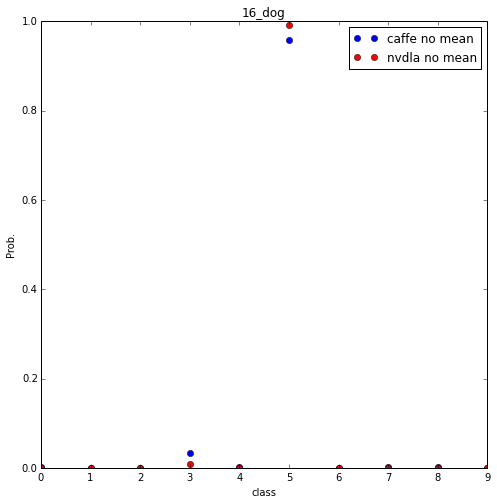

image: 59_cat 	 layer: prob	 diff: 0.104

NVDLA: [0.00868225 0.00211143 0.0102386  0.405762   0.233521   0.0431213
 0.0025177  0.0249481  0.0750122  0.19397   ] 

Caffe: [0.08369523 0.03178745 0.16100644 0.09088113 0.15256488 0.08246811
 0.07838782 0.04626471 0.20468554 0.06825867] 



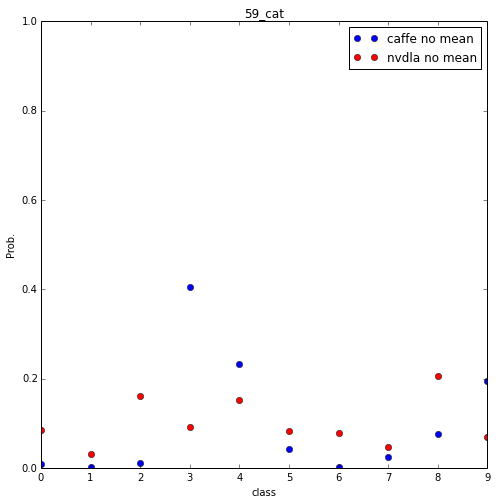

image: 9_automobile 	 layer: prob	 diff: 0.100

NVDLA: [0.00057602 0.00076485 0.00147438 0.53418    0.115295   0.262939
 0.0122452  0.0175934  0.0522766  0.00268555] 

Caffe: [0.0191712  0.00172196 0.03372198 0.15033232 0.05458762 0.71107394
 0.01476327 0.00605164 0.00631823 0.00225788] 



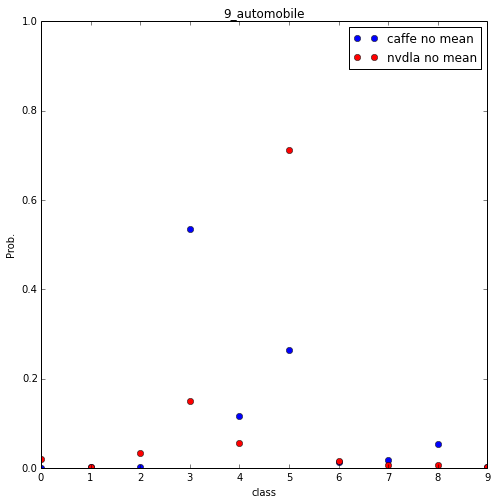

image: 13_horse 	 layer: prob	 diff: 0.189

NVDLA: [3.09944e-06 5.96046e-08 8.70228e-06 6.17218e-03 2.12288e-03 4.84619e-02
 4.76837e-07 9.43359e-01 5.91874e-05 8.34465e-07] 

Caffe: [1.21635014e-04 2.10972601e-07 5.90519048e-04 9.19574965e-03
 7.08254302e-05 9.89701867e-01 7.54767598e-06 2.46408035e-06
 3.07946058e-04 1.32618834e-06] 



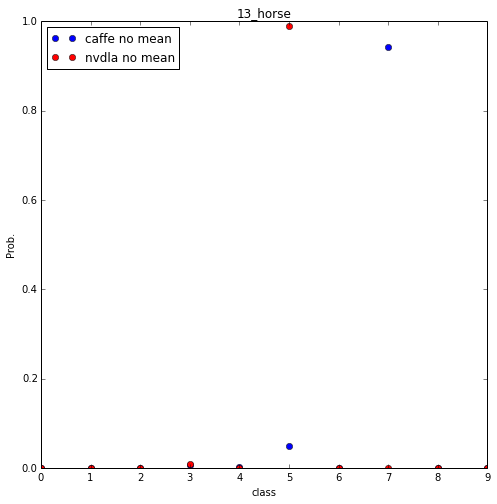

image: 53_truck 	 layer: prob	 diff: 0.061

NVDLA: [0.030304   0.0021286  0.00684357 0.11145    0.0328064  0.636719
 0.00189686 0.00693893 0.158691   0.0120697 ] 

Caffe: [1.36501179e-03 2.57754382e-05 4.83628223e-03 4.56246212e-02
 2.36123963e-03 9.43510115e-01 2.90288852e-04 1.11689114e-04
 1.80717360e-03 6.78452780e-05] 



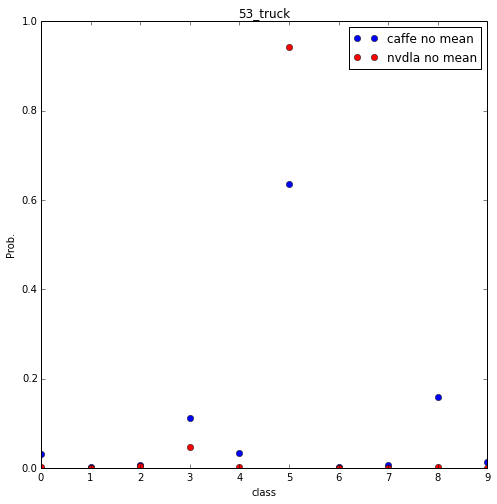

image: 114_horse 	 layer: prob	 diff: 0.190

NVDLA: [5.54276e-03 9.53674e-07 8.02612e-03 7.49512e-02 7.40723e-01 9.39941e-02
 1.22547e-03 7.49512e-02 3.92437e-04 7.09295e-06] 

Caffe: [2.2559994e-01 2.7985849e-05 7.2119731e-01 8.1421835e-03 1.7249412e-03
 2.4361506e-02 2.9801537e-04 4.0223944e-04 1.8218584e-02 2.7202375e-05] 



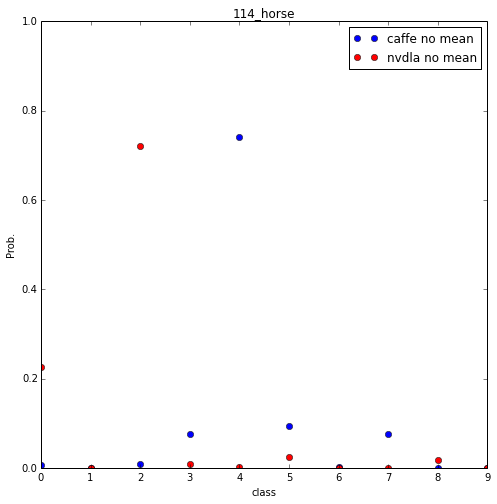

image: 67_truck 	 layer: prob	 diff: 0.095

NVDLA: [0.0226135  0.00936127 0.00116253 0.105469   0.0108337  0.257812
 0.00301552 0.00287056 0.575684   0.0111694 ] 

Caffe: [5.0583117e-02 1.9756943e-04 7.2336987e-02 1.0234541e-01 4.8260060e-03
 6.3385069e-01 2.7815085e-03 3.6379860e-03 1.2906793e-01 3.7288124e-04] 



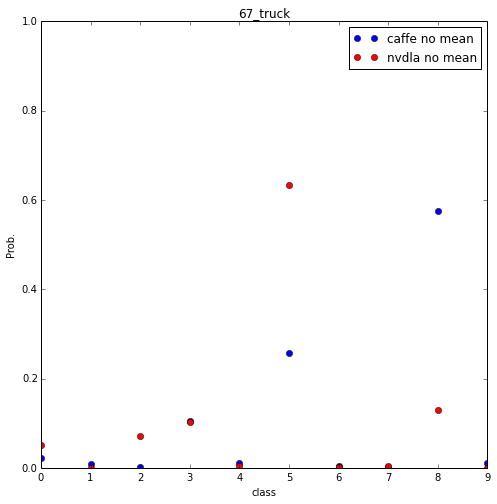

image: 18_ship 	 layer: prob	 diff: 0.199

NVDLA: [1.48416e-05 1.49131e-04 4.17233e-07 9.59635e-06 4.11272e-06 4.32134e-05
 1.60933e-06 1.96695e-06 9.99512e-01 6.61612e-05] 

Caffe: [3.2400277e-03 1.8286194e-04 9.6395947e-03 6.8745457e-02 6.8542706e-03
 9.0315765e-01 1.5203520e-03 5.7517906e-04 5.7529230e-03 3.3166949e-04] 



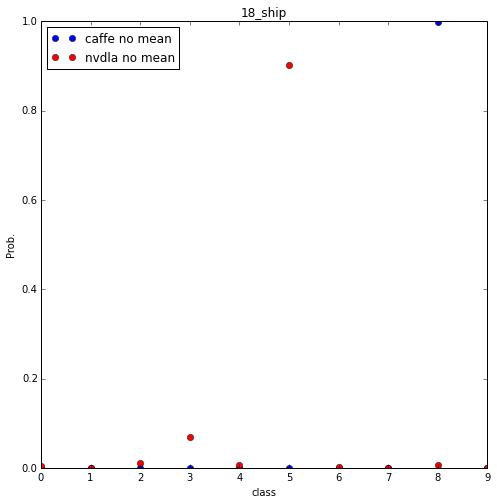

image: 107_dog 	 layer: prob	 diff: 0.044

NVDLA: [1.22643e-03 8.54135e-05 3.27454e-02 1.39526e-01 3.16772e-02 6.99219e-01
 1.78051e-03 5.38254e-03 8.54492e-02 3.02887e-03] 

Caffe: [6.7770532e-03 1.5916030e-06 2.1849709e-02 4.1682709e-02 5.8404106e-04
 9.1488004e-01 2.0480235e-04 1.9023780e-04 1.3818215e-02 1.1719220e-05] 



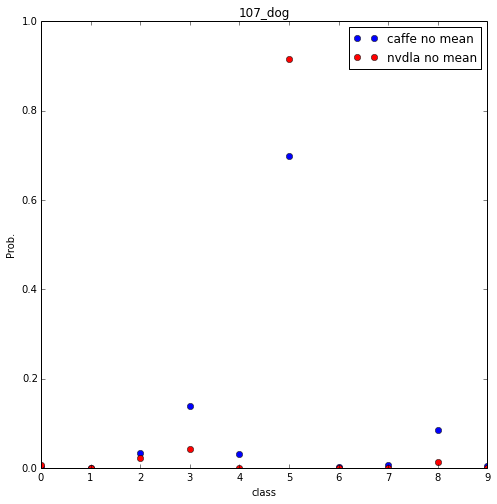

image: 68_horse 	 layer: prob	 diff: 0.141

NVDLA: [1.74809e-03 7.39098e-06 3.16811e-03 1.47827e-01 1.15356e-01 2.77344e-01
 1.11520e-04 4.51904e-01 2.70271e-03 4.76837e-06] 

Caffe: [4.13784262e-04 4.49696870e-07 2.53313873e-03 1.08133983e-02
 1.00962905e-04 9.84589934e-01 2.22971375e-05 1.49007228e-05
 1.50740612e-03 3.58437114e-06] 



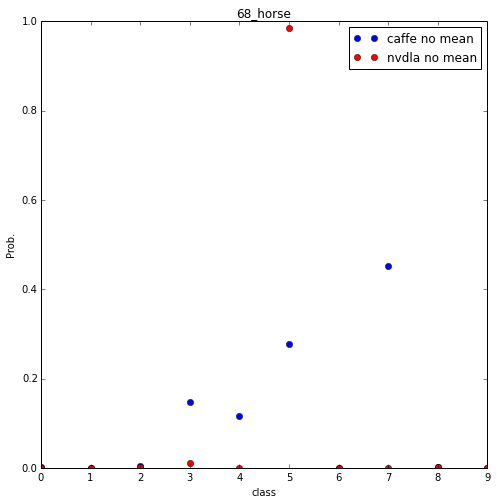

image: 21_cat 	 layer: prob	 diff: 0.080

NVDLA: [2.40356e-01 1.31130e-06 2.84882e-02 4.17725e-01 8.88824e-03 2.98584e-01
 8.53539e-04 3.50380e-03 1.57547e-03 7.21216e-06] 

Caffe: [0.08067512 0.00492129 0.19182794 0.17924176 0.05649465 0.29926202
 0.03205404 0.0529649  0.09838461 0.00417367] 



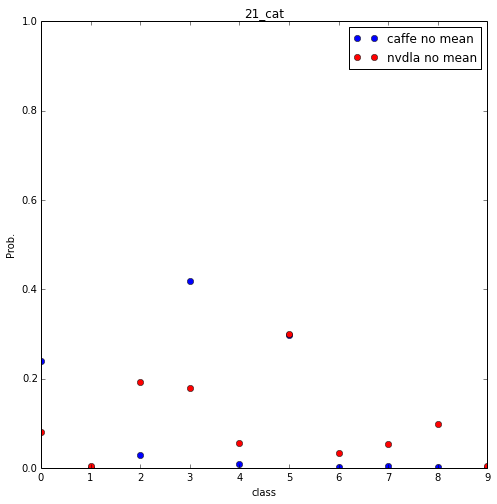

image: 63_bird 	 layer: prob	 diff: 0.112

NVDLA: [0.0565796  0.0139084  0.140747   0.153198   0.173828   0.142578
 0.00843048 0.226685   0.0308228  0.0531616 ] 

Caffe: [1.60269234e-02 2.50468380e-04 5.01008928e-02 1.20474674e-01
 9.77183059e-02 6.97502077e-01 1.17079839e-02 5.22335898e-03
 3.32328753e-04 6.63039682e-04] 



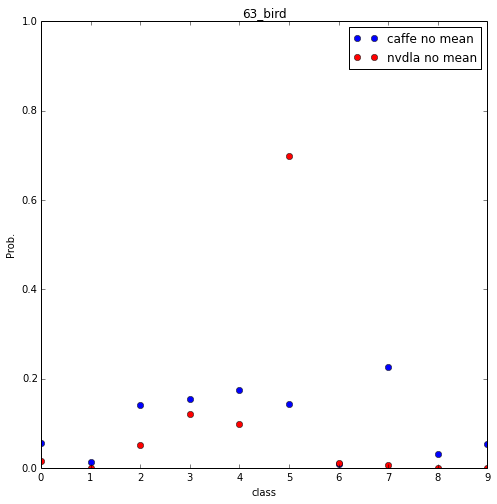

image: 110_truck 	 layer: prob	 diff: 0.171

NVDLA: [0.188965   0.00428772 0.0578613  0.0665894  0.0598145  0.0238647
 0.0270996  0.0188293  0.502441   0.050354  ] 

Caffe: [4.3244581e-03 5.2137504e-04 1.8476363e-02 9.4854653e-02 1.6602032e-02
 8.5256469e-01 2.5377981e-03 1.2876926e-03 8.0168368e-03 8.1413094e-04] 



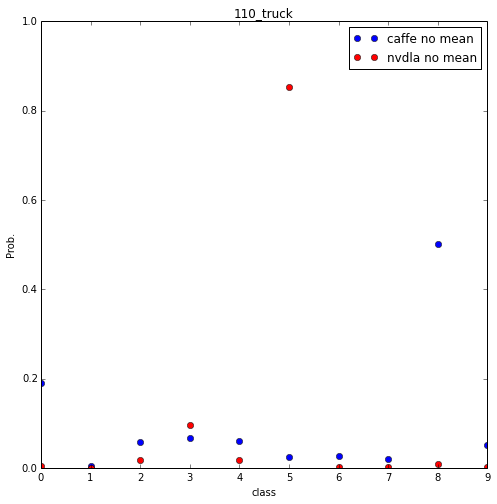

image: 85_horse 	 layer: prob	 diff: 0.063

NVDLA: [4.48990e-03 7.64132e-05 4.73022e-02 2.01050e-01 1.85699e-02 5.35645e-01
 9.77516e-04 1.84448e-01 4.22287e-03 3.02315e-03] 

Caffe: [2.4187468e-02 9.8476710e-05 7.8424782e-02 8.1800632e-02 5.9264135e-03
 6.7279905e-01 2.1855589e-03 2.7345447e-03 1.3132188e-01 5.2125164e-04] 



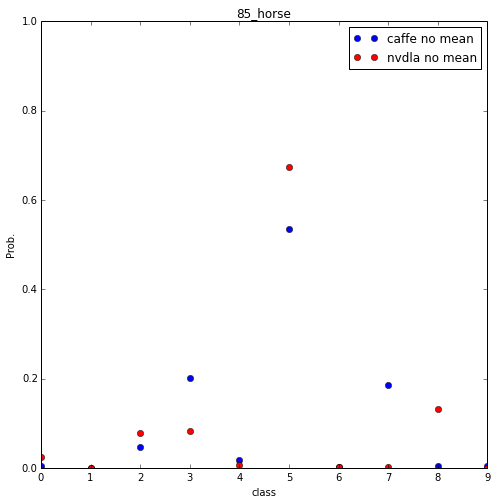

image: 105_automobile 	 layer: prob	 diff: 0.199

NVDLA: [9.69887e-04 2.85645e-01 7.62939e-06 3.77655e-03 5.26428e-04 9.56655e-05
 5.45025e-04 2.30074e-05 4.35791e-01 2.72705e-01] 

Caffe: [2.6570630e-04 2.9507441e-05 4.4395258e-03 4.7057390e-02 3.8281757e-02
 9.0867138e-01 5.9534493e-04 3.6380993e-04 2.7368724e-04 2.1756219e-05] 



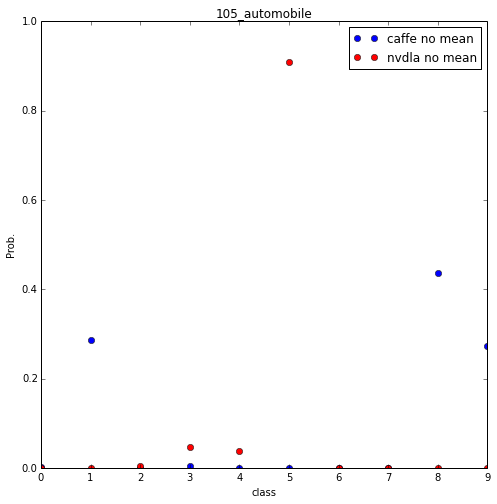

image: 115_airplane 	 layer: prob	 diff: 0.149

NVDLA: [3.68896e-01 1.49250e-03 1.33896e-03 2.69651e-04 8.27312e-05 7.65324e-05
 5.64456e-05 4.70877e-06 6.27441e-01 4.94480e-04] 

Caffe: [0.07301819 0.02246776 0.13962084 0.12611407 0.14929616 0.11947915
 0.07363956 0.06158576 0.17830247 0.05647596] 



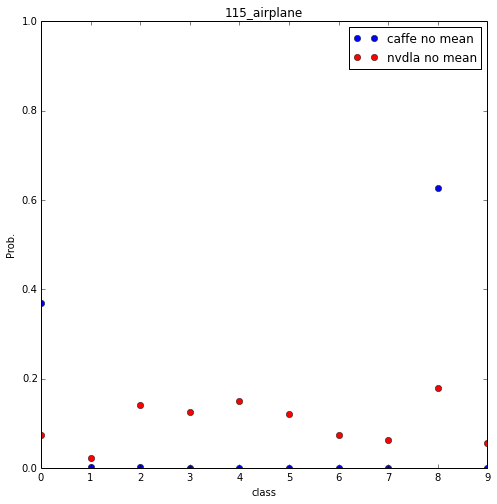

image: 21_airplane 	 layer: prob	 diff: 0.176

NVDLA: [9.58496e-01 0.00000e+00 4.11377e-02 1.06871e-04 1.62125e-05 4.76837e-07
 2.36034e-05 1.19209e-07 1.78814e-07 0.00000e+00] 

Caffe: [0.07698507 0.04460147 0.13758555 0.1222285  0.193027   0.0919788
 0.10647423 0.08360699 0.08750837 0.05600406] 



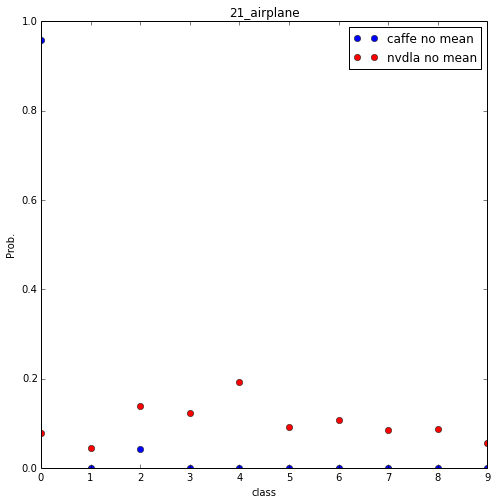

image: 103_frog 	 layer: prob	 diff: 0.022

NVDLA: [2.01607e-03 2.16722e-04 9.20868e-03 5.93262e-02 3.18604e-02 8.75977e-01
 6.05583e-04 1.89819e-02 1.41621e-03 3.47614e-04] 

Caffe: [7.1432552e-04 3.2785362e-08 2.5888605e-03 8.6031947e-03 3.7851547e-05
 9.8694462e-01 4.4007056e-06 1.2775342e-05 1.0936854e-03 2.5014049e-07] 



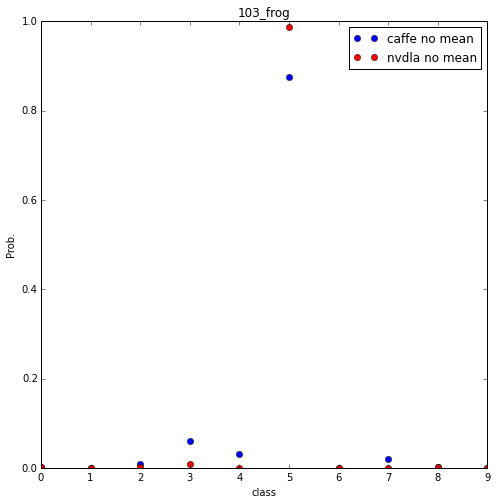

image: 112_automobile 	 layer: prob	 diff: 0.093

NVDLA: [0.00263023 0.0113831  0.00295639 0.352051   0.0875244  0.432129
 0.00435257 0.0269928  0.0570984  0.022995  ] 

Caffe: [1.4840525e-03 5.2794421e-05 6.1284699e-03 9.2529878e-02 3.8665636e-03
 8.9367205e-01 4.4800894e-04 2.3720010e-04 1.5428718e-03 3.8128437e-05] 



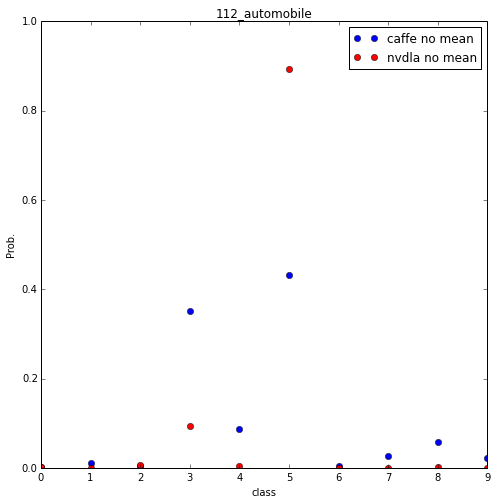

image: 5_automobile 	 layer: prob	 diff: 0.129

NVDLA: [1.20178e-01 2.03013e-04 6.40259e-02 1.93970e-01 1.36642e-02 2.59277e-01
 1.05209e-02 3.09563e-03 3.34229e-01 1.07193e-03] 

Caffe: [3.3769172e-01 9.7779630e-05 4.9049234e-01 4.7348056e-02 1.3055524e-02
 9.2590407e-02 2.1121348e-03 5.0485111e-03 1.1499218e-02 6.4325548e-05] 



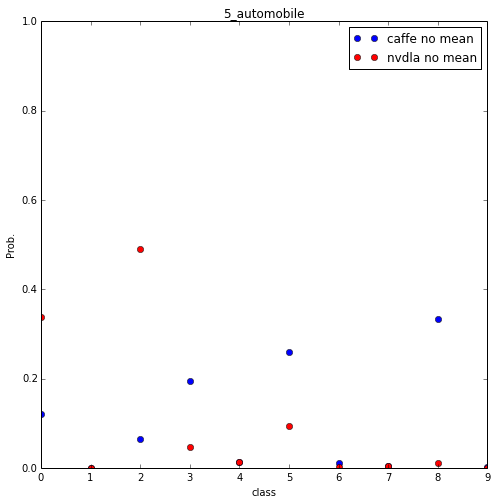

image: 1_ship 	 layer: prob	 diff: 0.200

NVDLA: [8.22544e-04 3.04222e-04 6.13928e-06 4.40121e-04 8.24928e-05 1.57952e-04
 3.23653e-05 2.30670e-05 9.98047e-01 1.87278e-04] 

Caffe: [3.1597886e-04 5.6420449e-06 1.3585618e-03 2.1598268e-02 1.2637660e-03
 9.7494406e-01 1.1704483e-04 2.3939972e-05 3.5612247e-04 1.6648843e-05] 



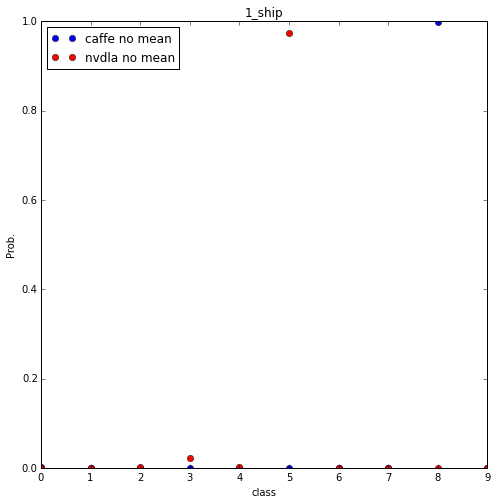

image: 98_deer 	 layer: prob	 diff: 0.116

NVDLA: [0.0160675  0.00479126 0.0246735  0.210205   0.203491   0.433105
 0.0262756  0.036438   0.0308228  0.0141678 ] 

Caffe: [2.1786107e-01 2.0452206e-04 4.0443715e-01 1.5692098e-01 2.4705663e-02
 1.6844583e-01 1.2415229e-02 3.0344834e-03 1.1635887e-02 3.3913035e-04] 



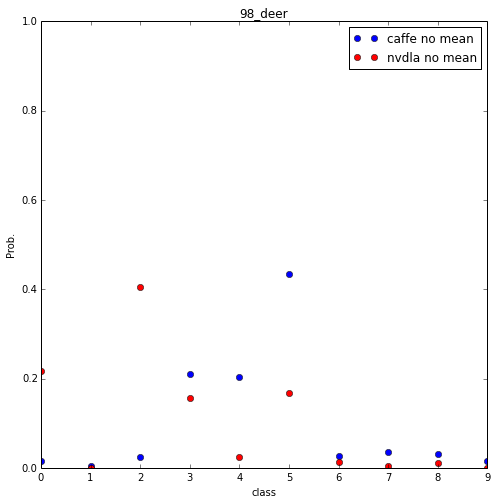

image: 104_frog 	 layer: prob	 diff: 0.096

NVDLA: [0.0988159  0.0470886  0.167847   0.144165   0.0147247  0.359863
 0.00663757 0.0368347  0.00224495 0.121643  ] 

Caffe: [1.8725339e-02 1.5850367e-06 8.0570295e-02 5.5104885e-02 2.3667780e-03
 8.3223200e-01 9.7955919e-05 2.9671314e-04 1.0590086e-02 1.4401738e-05] 



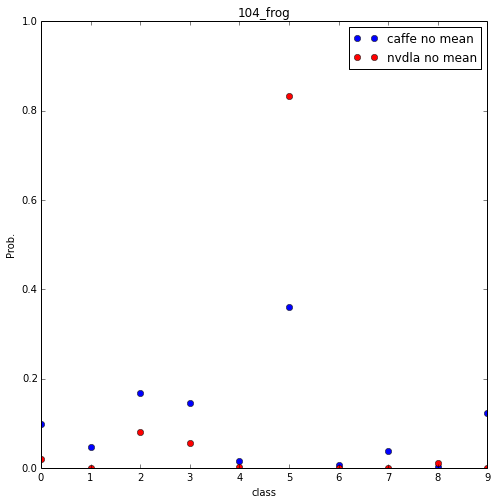

image: 61_automobile 	 layer: prob	 diff: 0.138

NVDLA: [1.98364e-03 8.81958e-03 4.11034e-04 9.44824e-02 5.74219e-01 3.02734e-01
 5.88894e-04 6.08826e-03 6.33621e-03 4.16565e-03] 

Caffe: [1.21221354e-04 1.87839578e-06 7.05992396e-04 7.50525156e-03
 1.94780601e-04 9.90189850e-01 1.81083487e-05 6.97650512e-06
 1.24580902e-03 1.02778749e-05] 



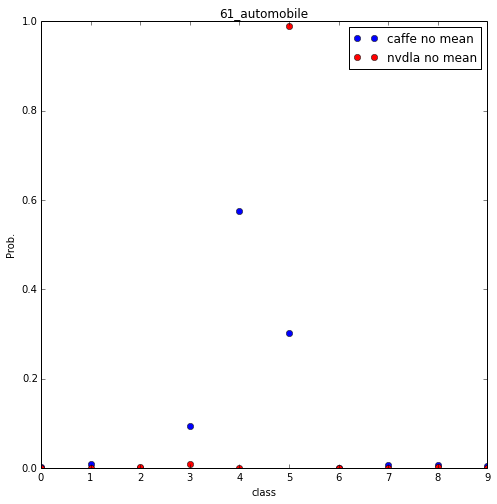

image: 34_deer 	 layer: prob	 diff: 0.130

NVDLA: [9.94263e-02 7.72476e-04 1.67542e-02 1.07056e-01 6.49414e-01 2.53296e-02
 5.72968e-03 4.18472e-03 9.07593e-02 6.09875e-04] 

Caffe: [0.09314016 0.00392819 0.18593244 0.06848538 0.04181674 0.2633883
 0.01610124 0.01083369 0.2962834  0.02009048] 



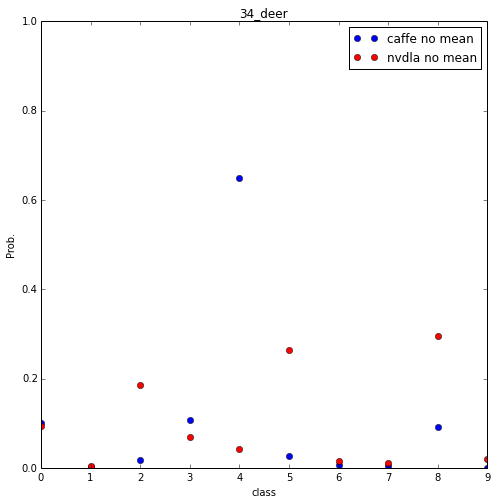

image: 87_horse 	 layer: prob	 diff: 0.089

NVDLA: [2.07520e-03 2.01106e-04 8.86536e-03 8.58154e-02 5.61035e-01 2.23511e-01
 1.19553e-02 1.02356e-01 3.44849e-03 8.63075e-04] 

Caffe: [0.16263144 0.00299389 0.12183953 0.12501602 0.20828061 0.27680603
 0.03240217 0.00812952 0.05308904 0.00881173] 



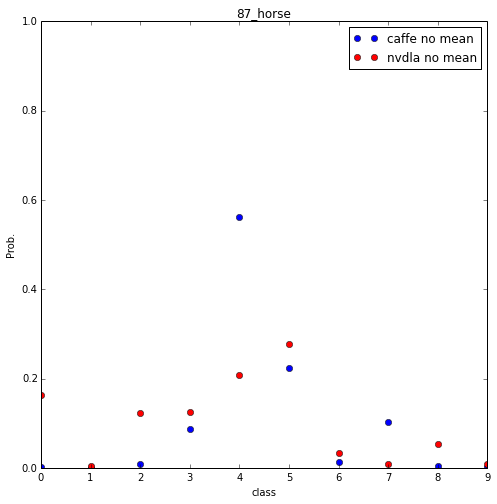

image: 43_horse 	 layer: prob	 diff: 0.143

NVDLA: [2.89551e-01 3.96967e-04 4.01917e-02 1.76636e-01 8.29468e-02 1.32324e-01
 1.22309e-04 2.75146e-01 2.74086e-03 1.10447e-04] 

Caffe: [2.0664704e-01 1.0217024e-04 7.0838517e-01 7.2373450e-03 8.1003299e-03
 1.7981937e-02 8.3918363e-04 9.1884664e-04 4.9695633e-02 9.2321345e-05] 



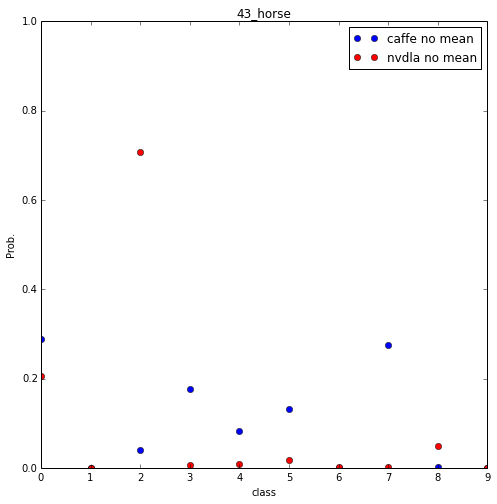

image: 92_ship 	 layer: prob	 diff: 0.107

NVDLA: [1.13907e-02 8.09431e-05 9.28402e-04 4.31152e-01 1.86890e-01 3.59375e-01
 4.77219e-03 4.69971e-03 6.39439e-04 4.89354e-05] 

Caffe: [1.2004708e-02 1.9986430e-05 1.1086053e-01 9.1460757e-02 1.3565347e-03
 7.4836951e-01 7.7033252e-04 8.2953676e-04 3.4293376e-02 3.4719567e-05] 



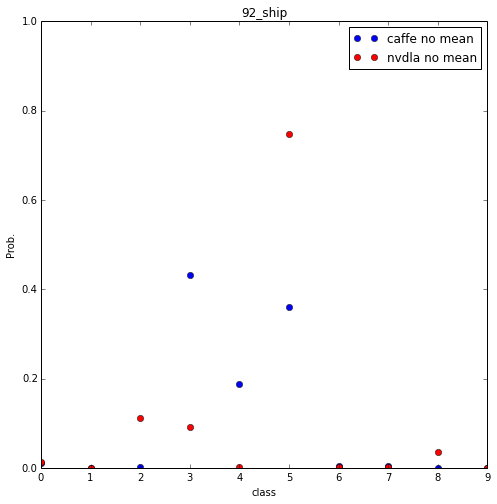

image: 118_truck 	 layer: prob	 diff: 0.098

NVDLA: [2.61068e-04 2.99454e-04 3.87430e-04 1.25610e-01 3.07922e-02 3.89893e-01
 4.42505e-04 4.59194e-04 4.51416e-01 4.95434e-04] 

Caffe: [2.6438581e-03 3.2504581e-04 8.7612644e-03 1.0174795e-01 1.2656362e-02
 8.6507082e-01 1.4675050e-03 1.0881189e-03 5.9494665e-03 2.8966693e-04] 



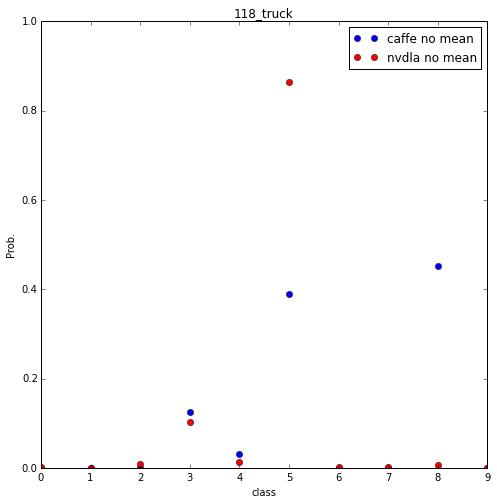

image: 4_automobile 	 layer: prob	 diff: 0.160

NVDLA: [1.16821e-01 5.92773e-01 2.76566e-04 4.93774e-02 6.32095e-03 1.23291e-01
 1.43814e-03 7.99561e-03 7.92847e-02 2.25372e-02] 

Caffe: [1.2604904e-02 4.6962823e-04 3.3073023e-02 1.7934230e-01 5.7487044e-02
 6.9769907e-01 1.3963911e-02 3.0836165e-03 1.8028918e-03 4.7360099e-04] 



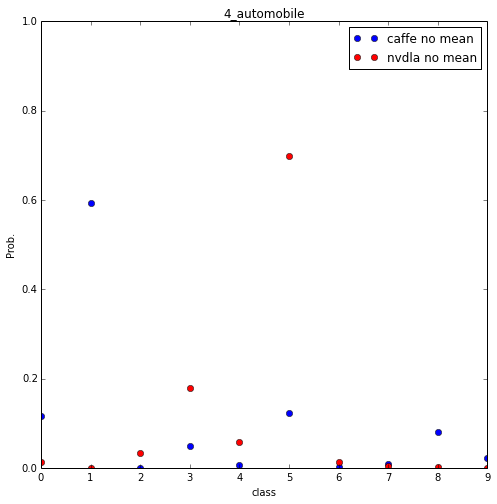

image: 16_truck 	 layer: prob	 diff: 0.180

NVDLA: [0.0015974  0.00377274 0.0129471  0.0311127  0.0648193  0.053833
 0.00221443 0.00465775 0.803711   0.0213165 ] 

Caffe: [1.8980185e-03 2.7330057e-05 8.8701742e-03 4.7283497e-02 1.9962441e-03
 9.3646491e-01 2.5858078e-04 2.4208022e-04 2.8922067e-03 6.7144756e-05] 



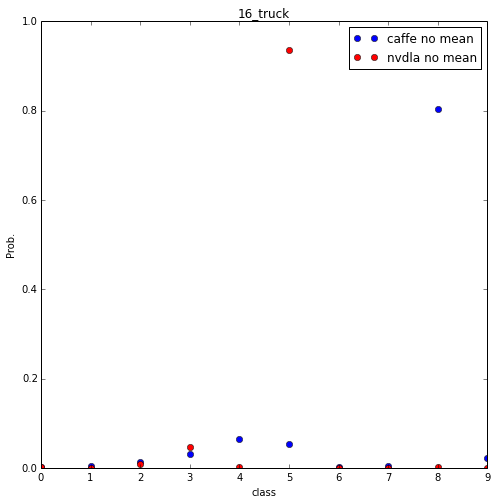

image: 8_ship 	 layer: prob	 diff: 0.087

NVDLA: [0.02034    0.00615311 0.0207367  0.226685   0.0402832  0.313477
 0.0179443  0.00756836 0.330322   0.0164032 ] 

Caffe: [6.8331449e-03 4.9527397e-04 4.4064086e-02 1.6356942e-01 9.3762748e-02
 6.7220706e-01 9.7856671e-03 3.5698193e-03 4.9536750e-03 7.5907685e-04] 



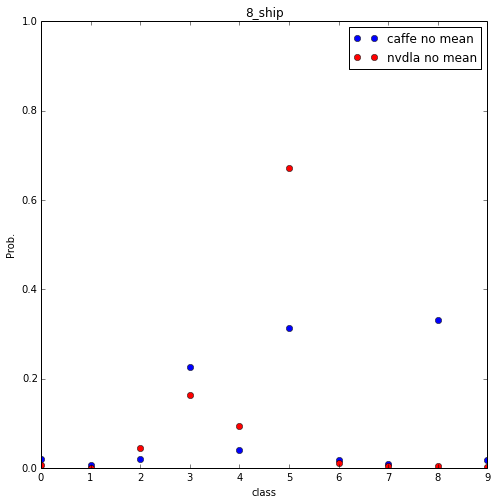

image: 8_cat 	 layer: prob	 diff: 0.008

NVDLA: [1.07348e-04 2.62260e-06 1.24359e-03 4.19006e-02 2.29950e-02 9.07715e-01
 1.26004e-04 5.04017e-04 2.51770e-02 3.51071e-05] 

Caffe: [4.6688286e-03 3.9171089e-05 9.8700263e-03 5.4066911e-02 2.3333593e-03
 9.2000347e-01 6.5336784e-04 3.0843023e-04 7.9328464e-03 1.2367762e-04] 



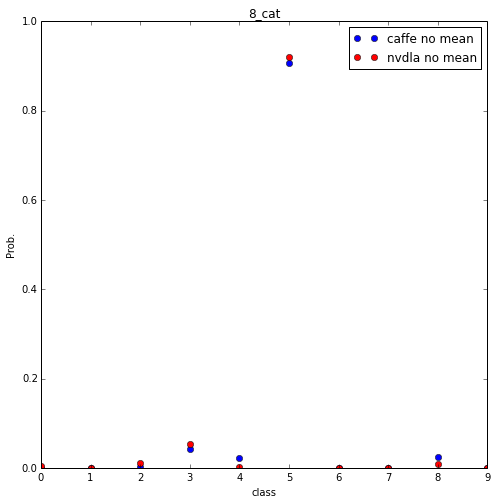

image: 128_dog 	 layer: prob	 diff: 0.080

NVDLA: [1.27335e-02 2.06828e-04 1.86157e-01 2.77344e-01 2.35840e-01 3.89099e-02
 4.67777e-04 2.46216e-01 8.22544e-04 1.38283e-03] 

Caffe: [0.02089338 0.00704991 0.06135893 0.29891434 0.18168557 0.301089
 0.02744524 0.0260573  0.06920697 0.00629939] 



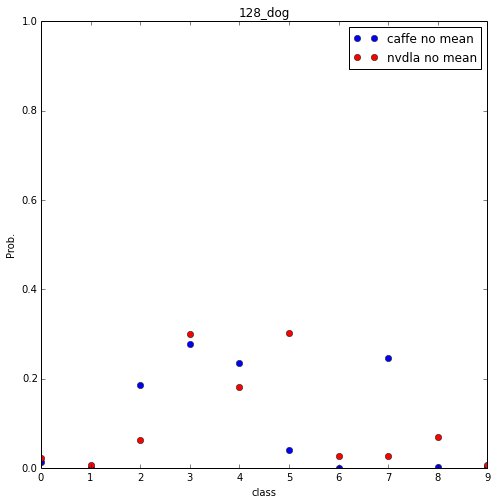

image: 12_dog 	 layer: prob	 diff: 0.029

NVDLA: [1.57776e-02 4.87804e-04 1.10703e-02 7.92236e-02 4.71497e-02 7.24121e-01
 2.50626e-03 2.67639e-02 9.00269e-02 2.84576e-03] 

Caffe: [1.0723825e-02 1.0780605e-05 6.9759734e-02 1.1738071e-01 3.1444582e-03
 7.7324837e-01 6.5306009e-04 7.6158333e-04 2.4266338e-02 5.1169358e-05] 



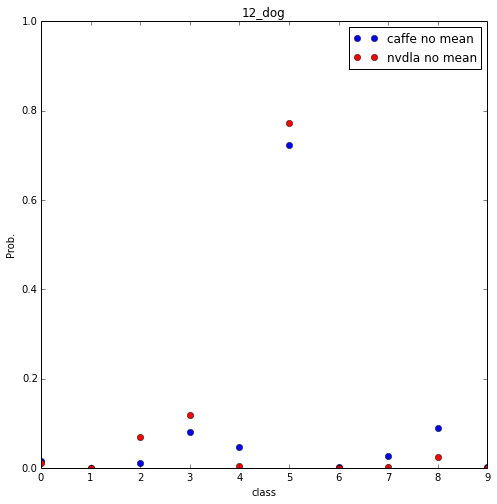

image: 11_horse 	 layer: prob	 diff: 0.118

NVDLA: [1.06812e-03 3.81470e-06 1.96075e-02 2.14111e-01 6.32812e-01 2.99530e-02
 3.55482e-04 8.41675e-02 1.78833e-02 9.71556e-06] 

Caffe: [0.06934538 0.00466844 0.1853927  0.20476998 0.09181134 0.30641568
 0.04030477 0.04236976 0.05003664 0.00488526] 



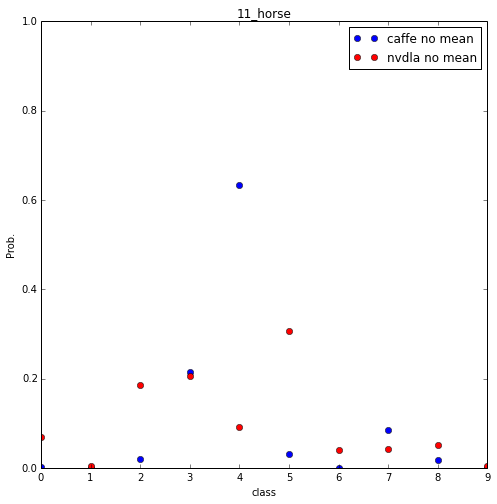

image: 0_cat 	 layer: prob	 diff: 0.015

NVDLA: [8.90255e-04 2.39611e-04 9.62734e-04 8.01392e-02 2.31934e-02 7.66602e-01
 3.55482e-04 2.05383e-02 1.04553e-01 2.75230e-03] 

Caffe: [2.0318188e-02 4.8376989e-04 5.0705578e-02 7.3081359e-02 1.0336371e-02
 7.4831384e-01 4.3056635e-03 2.2919504e-03 8.7664060e-02 2.4992260e-03] 



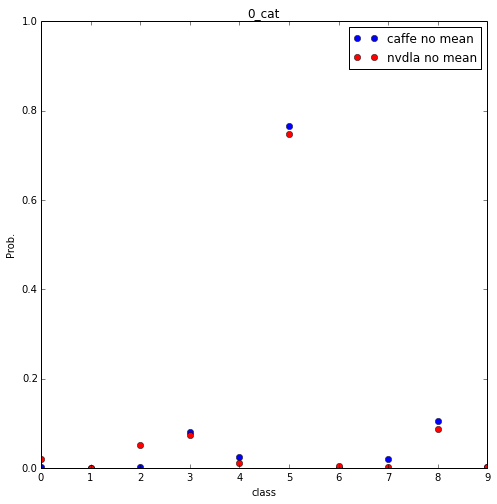

image: 14_truck 	 layer: prob	 diff: 0.199

NVDLA: [2.29478e-05 3.61204e-05 8.49366e-05 1.85680e-03 9.64165e-04 2.06113e-04
 9.98378e-05 2.03371e-04 9.66797e-01 2.99072e-02] 

Caffe: [0.01496865 0.00130974 0.08107639 0.14213718 0.1398945  0.5956692
 0.01449887 0.00658449 0.00192609 0.00193493] 



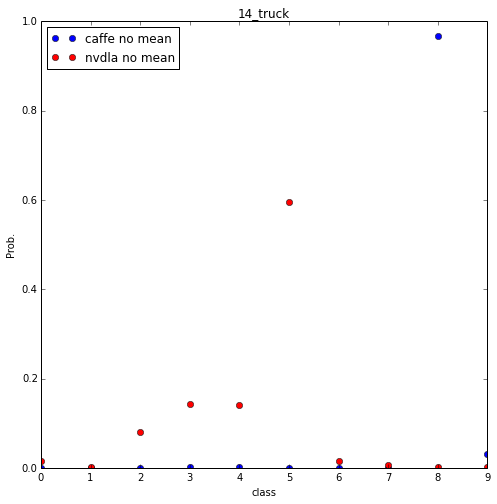

image: 27_dog 	 layer: prob	 diff: 0.064

NVDLA: [3.17335e-04 2.55704e-05 3.26729e-03 1.94336e-01 3.22998e-01 4.22852e-01
 5.78690e-03 4.83398e-02 1.78719e-03 1.31965e-04] 

Caffe: [0.04812941 0.01397973 0.14511193 0.17844154 0.23982446 0.20834866
 0.06516977 0.04425941 0.04111052 0.01562447] 



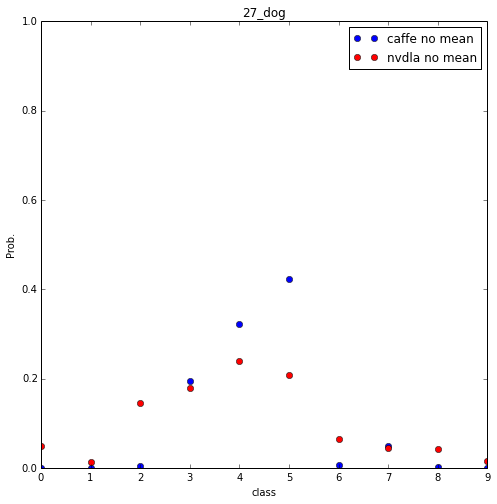

image: 10_airplane 	 layer: prob	 diff: 0.101

NVDLA: [5.02014e-03 6.37174e-05 9.92584e-03 1.77490e-01 3.35938e-01 4.56299e-01
 5.81264e-04 4.66156e-03 1.00403e-02 8.73804e-05] 

Caffe: [2.2828532e-03 9.0281046e-06 3.9563007e-03 2.6824078e-02 8.8059017e-04
 9.6371919e-01 2.6683035e-04 6.2663647e-05 1.9501145e-03 4.8265036e-05] 



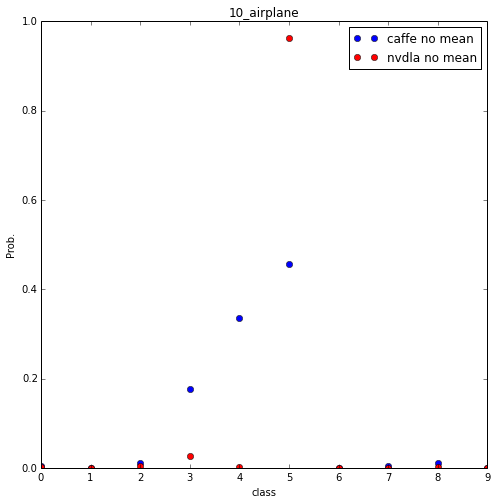

image: 20_horse 	 layer: prob	 diff: 0.098

NVDLA: [0.00549316 0.00470352 0.0230103  0.26416    0.419189   0.107788
 0.00380898 0.110962   0.0490112  0.0117874 ] 

Caffe: [0.12426397 0.01457654 0.24062279 0.1402586  0.11563483 0.16232787
 0.03793563 0.05038513 0.09539429 0.01860033] 



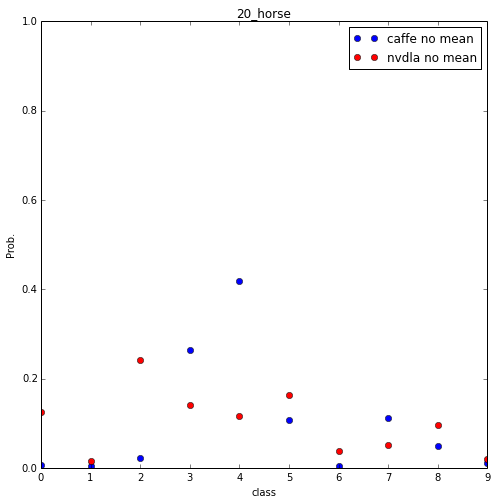

image: 11_truck 	 layer: prob	 diff: 0.195

NVDLA: [2.66075e-04 5.01633e-03 6.29425e-05 7.07626e-03 6.57272e-03 3.79181e-03
 2.13385e-05 7.56383e-05 7.19238e-01 2.58057e-01] 

Caffe: [1.3306039e-02 3.6368796e-04 1.7403161e-02 1.0965174e-01 1.8418387e-02
 8.2617348e-01 6.6882316e-03 1.9116354e-03 4.9381624e-03 1.1454852e-03] 



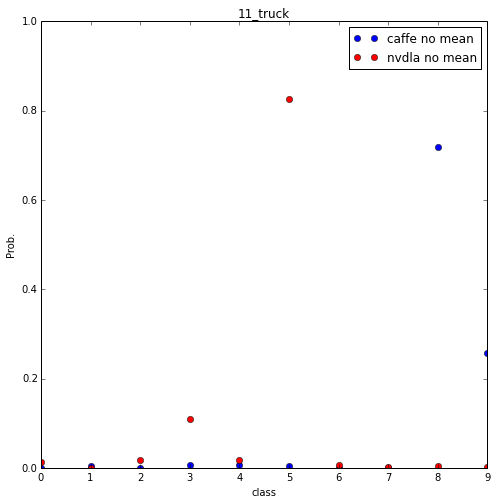

In [19]:
# pixel_width = 6
# pixel_height = 6
# plt.figure(figsize=(pixel_width, pixel_height))
aa = range(0,10)
for result in result_list:
    if result['layer'] == "prob":
        l1, = plt.plot(aa,result['nvdla'], 'bo' , label = 'caffe no mean')
        l2, = plt.plot(aa,result['caffe'], 'ro' , label = 'nvdla no mean')


        plt.xlim((0, 9))
        plt.ylim((0, 1))
        plt.title(result['image_name'])
        plt.xlabel('class')
        plt.ylabel('Prob.')
        
        plt.legend(loc = 'best') #, labels = ['caffe', 'no mean'], loc = 'best')
        print ("==============================================================================")
        print ("image: %s \t layer: %s\t diff: %.3f\n"%(result['image_name'],result['layer'],result['diff']))
        print "NVDLA:", result['nvdla'],"\n"
        print "Caffe:", result['caffe'],"\n"
        plt.show()
        
